In [24]:
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm

# Load paths

In [25]:
train_df = pd.read_csv("data/path/train.csv")
test_df = pd.read_csv("data/path/test.csv")
val_df = pd.read_csv("data/path/val.csv")

print("Train: ", train_df.shape)
print("Test: ", test_df.shape)
print("Val: ", val_df.shape)


Train:  (3073, 2)
Test:  (391, 2)
Val:  (440, 2)


# Extract spectrogram

In [26]:
def create_dataset(df, sr=22050, n_mels=128, hop_length=512,augment_data=False):
    """
    Extract feature (logmel, delta, delta2)
    
    Args:
        df: dataframe with path of file and associated emotion
        sr: sampling rate
        n_mels: mels coefficient selected
        hop_length: window overlapping
        augment_data: if True, data augmentation is performed
     
        
    Returns:
        (X, :Extracted feature array [(n_mels, max_len, 3)]
        y   :Associated label array
        )
    """
    def min_max_normalize(X):
        """
        Min max normalize within each channel
        
        Args:
            X: stack of channels
        
            
        Returns:
            X: stack of normalized channels
        """
        for stack in X:
            for c in stack:
                min_value = np.min(c)
                max_value = np.max(c)
                c -= min_value  # Traslare i valori
                if max_value > min_value:  # Evitare divisione per zero
                    c /= (max_value - min_value)  # Normalizzare
        return X
    
    def pad(spectrograms, target_width):
        """
        Aggiunge padding a ciascuno spettrogramma in una lista, considerando i canali (logmel, delta).

        Args:
            spectrograms (list of np.ndarray): Lista di spettrogrammi con forma (n_mels, len, n_channels).
            target_width (int): Larghezza desiderata per gli spettrogrammi.

        Returns:
            list of np.ndarray: Lista di spettrogrammi con padding aggiunto.
        """
        padded_spectrograms = []
        for spectrogram in spectrograms:
            n_mels, original_width, n_channels = spectrogram.shape
            padding_total = target_width - original_width
            
            if padding_total < 0:
                raise ValueError(f"Il target_width ({target_width}) è inferiore alla larghezza originale ({original_width}).")

            padding_left = padding_total // 2
            padding_right = padding_total - padding_left

            padded_spectrogram = np.pad(
                spectrogram,
                pad_width=((0, 0), (padding_left, padding_right), (0, 0)),  # Aggiunge padding solo sull'asse temporale
                mode='constant',
                constant_values=0
            )
            padded_spectrograms.append(padded_spectrogram)

        return padded_spectrograms

    def trim(spectrograms, target_width):
        """
        Taglia o aggiunge padding per ottenere una larghezza target specificata, considerando i canali.

        Args:
            spectrograms (list of np.ndarray): Lista di spettrogrammi con forma (n_mels, len, n_channels).
            target_width (int): Larghezza desiderata per gli spettrogrammi.

        Returns:
            list of np.ndarray: Lista di spettrogrammi aggiustati alla larghezza target.
        """
        trimmed_spectrograms = []
        for spectrogram in spectrograms:
            n_mels, original_width, n_channels = spectrogram.shape

            if original_width < target_width:
                trimmed_spectrogram = pad([spectrogram], target_width)[0]  # Restituisce un array, si prende il primo elemento
            else:
                # Calcola gli indici per il taglio
                start_index = (original_width - target_width) // 2
                end_index = start_index + target_width

                # Taglia la parte centrale
                trimmed_spectrogram = spectrogram[:, start_index:end_index, :]
            
            trimmed_spectrograms.append(trimmed_spectrogram)

        return trimmed_spectrograms




    X = []  # Feature (log-mel spectrograms)
    y = []  # Labels (emotions)

    for row in tqdm(df.itertuples(index=False), total=len(df)):
        path = row.path
        emotion = row.emotion
        audio,_ = librosa.load(path, sr=sr)

        audio_array = []
        audio_array.append(audio)

        if augment_data:
            if emotion == 6:

                #DATA AUGMENTATION
                #speed up
                audio_stretched = librosa.effects.time_stretch(y=audio, rate=1.1)  # speend up by 10%
                #pitch up
                audio_pitched = librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=2)  
                # 0.5 time shift
                shift = int(0.5 * sr) 
                audio_shifted = np.roll(audio, shift)
                # noise injection
                noise = np.random.normal(0, 0.05, len(audio))
                audio_noisy = audio + noise 

                #audio_array.append(audio_stretched)
                audio_array.append(audio_pitched)
                #audio_array.append(audio_shifted)
                audio_array.append(audio_noisy)
            
        # Extract features
        for audio in audio_array:
            mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length)
            log_mel = librosa.power_to_db(mel, ref=np.max)
            
            delta = librosa.feature.delta(log_mel)
            #delta2 = librosa.feature.delta(log_mel, order=2)

            feature = np.stack([log_mel, delta], axis=-1)
      
                    
            #if feature.shape[1] > max_len:
             #   print(feature.shape[1])
              #  max_len = feature.shape[1]
                    
            X.append(feature)
            y.append(emotion)
            
    
    X = min_max_normalize(X)
    X = trim(X, 200)
    print(X[0].shape)
    X = np.array(X)  
    y = np.array(y) 
    return X, y
  

In [27]:
X_train, y_train = create_dataset(train_df, augment_data=False)
X_val, y_val = create_dataset(val_df, augment_data=False)
X_test, y_test = create_dataset(test_df, augment_data=False)

print("Train: ", X_train.shape)
print("Val: ", X_val.shape)
print("Test: ", X_test.shape)

100%|██████████| 3073/3073 [00:14<00:00, 218.95it/s]


(128, 200, 2)


100%|██████████| 440/440 [00:02<00:00, 160.81it/s]


(128, 200, 2)


100%|██████████| 391/391 [00:02<00:00, 161.99it/s]


(128, 200, 2)
Train:  (3073, 128, 200, 2)
Val:  (440, 128, 200, 2)
Test:  (391, 128, 200, 2)


# Plot

## Spectrogram

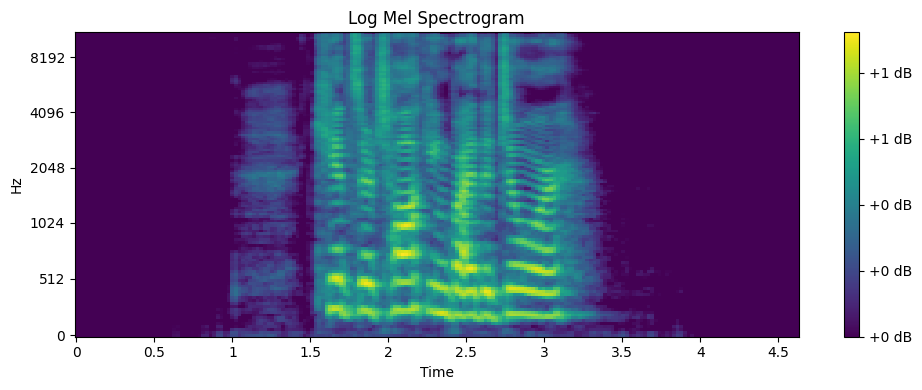

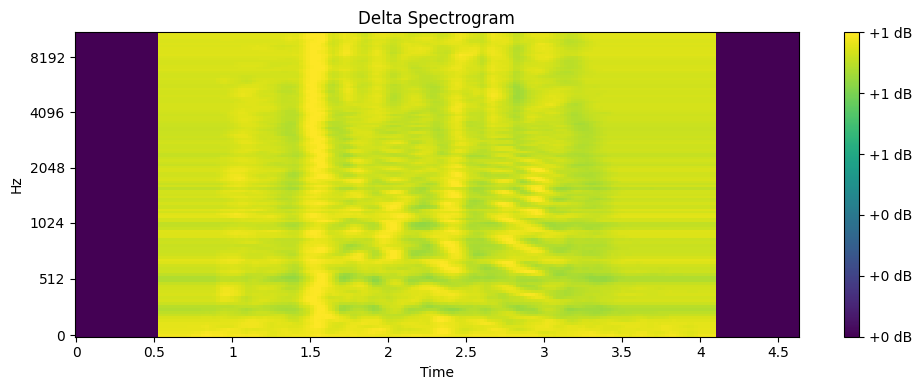

In [28]:
def plot_spectogram(spec,sr = 22050, title = "Spectrogram"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spec, sr=sr, hop_length=512, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

sample = 400
plot_spectogram(X_train[sample][:,:,0], title = "Log Mel Spectrogram")
plot_spectogram(X_train[sample][:,:,1], title = "Delta Spectrogram")

## Class distributions

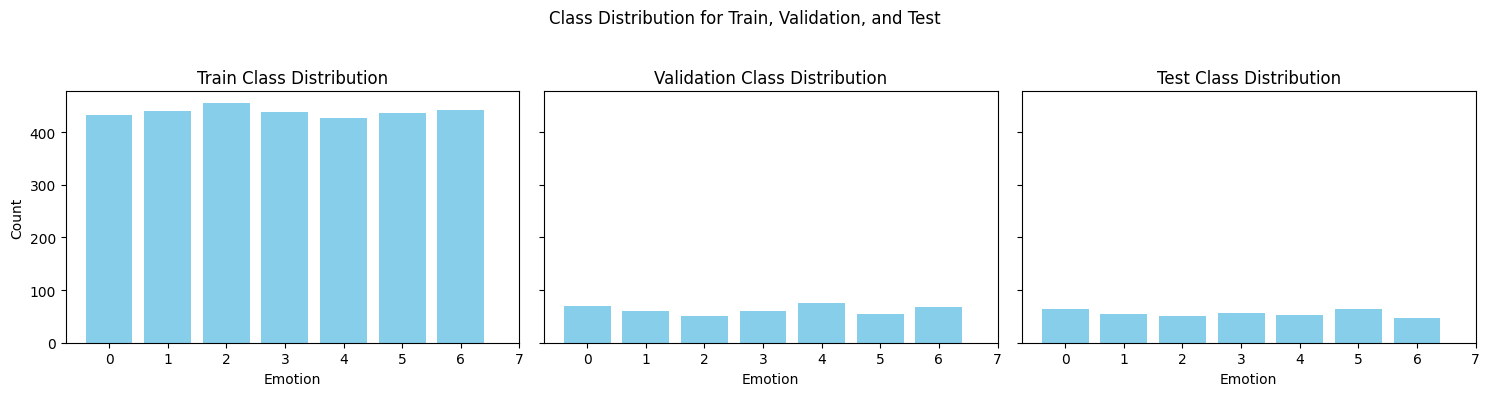

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

axs[0].hist(y_train, bins=range(8), rwidth=0.8, align='left', color='skyblue')
axs[0].set_title('Train Class Distribution')
axs[0].set_xlabel('Emotion')
axs[0].set_ylabel('Count')
axs[0].set_xticks(range(8))

axs[1].hist(y_val, bins=range(8), rwidth=0.8, align='left', color='skyblue')
axs[1].set_title('Validation Class Distribution')
axs[1].set_xlabel('Emotion')
axs[1].set_xticks(range(8))

axs[2].hist(y_test, bins=range(8), rwidth=0.8, align='left', color='skyblue')
axs[2].set_title('Test Class Distribution')
axs[2].set_xlabel('Emotion')
axs[2].set_xticks(range(8))

plt.suptitle('Class Distribution for Train, Validation, and Test')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Save dataset

In [30]:
def save_dataset(X_train, X_val, X_test, y_train, y_val, y_test, output_dir="data/processed_data_spectro"):
    os.makedirs(output_dir, exist_ok=True)
    np.save(os.path.join(output_dir, "X_train.npy"), X_train)
    np.save(os.path.join(output_dir, "X_val.npy"), X_val)
    np.save(os.path.join(output_dir, "X_test.npy"), X_test)
    np.save(os.path.join(output_dir, "y_train.npy"), y_train)
    np.save(os.path.join(output_dir, "y_val.npy"), y_val)
    np.save(os.path.join(output_dir, "y_test.npy"), y_test)

save_dataset(X_train, X_val, X_test, y_train, y_val, y_test)